Python에서 Keras를 활용한 딥러닝 강의
- Skin cancer classification

  실습자료 다운로드: **http://www.snubi.org/Python_ML/python_data2.zip** 
 

Skin melanoma vs Bowen's disease

#tensorflow, keras, opencv-python, pillow, scikit-lot, matplotlib 등 라이브러리 설치 필요



https://www.python.org/ftp/python/3.6.7/python-3.6.7-amd64.exe

- python -m pip install --upgrade pip


- pip install ipython

- pip install notebook


- pip install tensorflow

- pip install keras


- pip install opencv-python

- pip install pillow

- pip install scikit-plot

- pip install matplotlib

- pip install pandas

In [2]:
#python -m pip install --upgrade pip
#pip install ipython

#pip install notebook

#pip install tensorflow

#pip install keras

#pip install opencv-python

#pip install pillow

!pip install scikit-plot

#pip install matplotlib

#pip install pandas

In [3]:
import tensorflow as tf
import numpy as np
import keras
import cv2
import os


import scikitplot as skplt
import matplotlib.pyplot as plt

In [5]:
from keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.pooling import AveragePooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import keras.backend as K
#from keras.optimizers import SGD
from keras.models import Model

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import pandas as pd

In [ ]:
tf.compat.v1.disable_eager_execution()

# Warm-up : Baseline model

기본 baseline_model은 입력층으로 3개의 데이터를 받아, 3개 뉴런의 Hidden layer를 가지고,

출력층은 하나의 값만을 출력하는 기본 Linear function이다.

In [6]:
def baseline_model():
    model = models.Sequential()
    model.add(layers.Dense(3, input_dim=3, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    #Compile model
    
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

training 데이터와, 결과값을 저장한다.

예제로 사용하는 데이터는 y = x+1 함수의 linear function이므로,

y_train 값은 x_train의 list에 해당하는 숫자의 합 +1로 구성하였다.

In [7]:
x_train = np.array([[1,2,3], [3,4,1], [2,6,2], [4,3,1], [6,5,4]])
y_train = np.array([7, 9, 11, 9, 16])

x_test = np.array([[1,1,1], [2,2,2]])

학습되는 과정을 loss값을 통해 확인한다.

loss는 mean_squared_error, 최소제곱평균으로 정의했으므로 얼마나 y_train값에 근접하느냐를 뜻한다.

In [8]:
model = baseline_model()
history = model.fit(x_train, y_train, batch_size=1000, epochs = 2000)

model.predict(x_test)

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 105.1298
Epoch 2/2000
1/1 [==============================] - 0s 10ms/step - loss: 104.8508
Epoch 3/2000
1/1 [==============================] - 0s 6ms/step - loss: 104.5726
Epoch 4/2000
1/1 [==============================] - 0s 14ms/step - loss: 104.2951
Epoch 5/2000
1/1 [==============================] - 0s 4ms/step - loss: 104.0183
Epoch 6/2000
1/1 [==============================] - 0s 12ms/step - loss: 103.7422
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 103.4668
Epoch 8/2000
1/1 [==============================] - 0s 10ms/step - loss: 103.1923
Epoch 9/2000
1/1 [==============================] - 0s 8ms/step - loss: 102.9184
Epoch 10/2000
1/1 [==============================] - 0s 5ms/step - loss: 102.6454
Epoch 11/2000
1/1 [==============================] - 0s 4ms/step - loss: 102.3731
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 102.1016
Epoch 13/2000
1/1 [===

array([[4.5072885],
       [7.376898 ]], dtype=float32)

[1, 1, 1], [2, 2, 2]를 test데이터로 사용하였으므로, 4와 7이 나올것으로 기대할 수 있다.

In [13]:
model.predict(x_test)

array([[4.5072885],
       [7.376898 ]], dtype=float32)

# Image classification

데이터 경로 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
CurrentDirectory = "/content/drive/MyDrive/EWHA_Syspharm/2021-2 (1학기)/유전체정보분석교육/Day1 - python/data1/python_ml"

train_directory = CurrentDirectory + '/TRAIN/'
test_directory	= CurrentDirectory + '/TEST/'
model_directory = CurrentDirectory + '/MODEL/'
tensorboard_directory = CurrentDirectory + '/Tensorboard/'

In [10]:
cd /content/drive/MyDrive/EWHA_Syspharm/2021-2 (1학기)/유전체정보분석교육/Day1 - python/data1/python_ml

/content/drive/MyDrive/EWHA_Syspharm/2021-2 (1학기)/유전체정보분석교육/Day1 - python/data1/python_ml


In [11]:
!pwd

/content/drive/MyDrive/EWHA_Syspharm/2021-2 (1학기)/유전체정보분석교육/Day1 - python/data1/python_ml


In [12]:
!ls

Heatmap_example  Python_DeepLearning_0517.ipynb  Tensorboard  TRAIN
MODEL		 Source.py			 TEST


*Batch size*는 CPU 혹은 GPU에 한번의 학습에 들어갈 Queue에 이미지의 수.

높을수록 효율적이지만, GPU의 메모리를 고려해서 선정해야함.


*epoch*는 전체 Training를 한번씩 학습하는 것을 의미한다.

따라서 epoch의 수는 전체 데이터를 몇번 학습할지에 대한 횟수를 의미


*Learning Rate*는 Back-propagation에서 Error를 줄이는 방향으로 Weight를 수정할 때,

얼마나 큰 수정을 가할것이냐에 대한 수치


*Decay*는 Learning rate의 update값.

학습할수록 점점 작은 Learning rate가 필요.


*img_width, img_height는 학습된 Neural network 구조에 동일한 input size가 필요하다.

보통 224를 많이 사용한다.

In [14]:
batch_size = 15
epochs = 300
LearningRate = 1e-3
Decay = 1e-6
img_width = 224
img_height = 224

Convolutional Neural Network 알고리즘들 중, 대표적인 VGG16 모델의 구성요소를 직접 구현한다.
layer를 많이 쌓아서 정확도를 높인다



In [15]:
def VGG_16():
	model = Sequential()
	model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
	model.add(Conv2D(64, (3, 3), activation='relu'))  #Filter size 
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(128, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(128, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(256, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Conv2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))
	
	#top layer of the VGG net
	return model

Binary classification을 구현하는 것으로, 최종 Fully connected layer의 units를 2로 설정한다.

GlobalAveragePooling2D 는 최종적으로 Classification 이후, Attention Heatmap을 그리기 위한 Layer이다.

softmax는 Sigmoid function의 general한 함수.

momentum은 Learning rate에 의한 Gradient Descent의 방향성에 관성을 주는것. (너무 와리가리 하면 local minimum에 빠지기 쉬움)

In [19]:
vggModel = VGG_16()
x = GlobalAveragePooling2D()(vggModel.output)
predictions = Dense(2, activation='softmax')(x)
DeepLearning = Model(inputs=vggModel.input, outputs=predictions)

DeepLearning.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LearningRate,decay=Decay,
	momentum=0.9,nesterov=True),loss='categorical_crossentropy',metrics=['acc'])

Keras에서 Generator는 자동으로 Data를 load해주는 역할을 함.

데이터를 불러올 때, 이미지를 자동으로 전처리 하는 코드를 Argument로 삽입할 수 있음

- Rescale: [0-255] 데이터를 [0-1] scale로 변환
- rotation_range: 이미지를 각도를 돌려가면서 학습시켜줄 수 있음
- shift_range: 이미지를 shift
- shear_range: 이미지에 왜곡을 줌
- zoom_rnage: 이미지를 확대
- flip: 뒤집기
- featurewise_center, std_normalization: 이미지 분포 변환
- data_format: RGB 3채널은 데이터의 마지막에 들어감. ex) [224, 224, 3]

In [20]:
#data를 차례대로 input해주는 함수 

DATAGEN = ImageDataGenerator(
	rescale=1./255,
	rotation_range=20,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	zoom_range=0.2, 
	horizontal_flip=True,
	vertical_flip=True,
	featurewise_center=True,
	featurewise_std_normalization=True,
	data_format="channels_last")

#augmentation information - data를 인위적으로 변화시켜서 training을 도움 -> test에서는 rotation ~ flip 은 제외해야함 

In [21]:
DATAGEN_TEST = ImageDataGenerator(
	rescale=1./255,
	featurewise_center=True,
	featurewise_std_normalization=True,
	data_format="channels_last")

Test 데이터 용으로 Generator를 생성.

모델의 성능을 판단할 Test dataset은 Augmentation을 수행하면 안됨.

In [24]:
TRAIN_GENERATOR = DATAGEN.flow_from_directory(
	train_directory,
	target_size = (img_width, img_height),
	batch_size = batch_size,
	class_mode='categorical')

TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
	test_directory,
	target_size = (img_width, img_height),
	batch_size = batch_size,
	shuffle = False,
	class_mode='categorical')

Found 540 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


540개의 이미지가 Training data로 읽혀짐

60개의 이미지가 Test data로 읽혀짐.

단 Augmentation은 Training data에만 적용

In [26]:
CP = ModelCheckpoint(filepath=model_directory+
					'-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
					monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#save weights 

TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)
CALLBACK = [CP, TB, LR]

ModelCheckpoint는 학습을 진행하면서 생성된 모델의 weight를 저장함

TensorBoard는 학습의 진행사항에 대한 log와 모델의 정보를 보는 기능

LearningRate를 자동으로 수정해주는 Plateau


위 3가지를 학습하면서 자동으로 실행하여, 매 학습마다 저장해주는 기능을 CallBack이라고 함.

In [27]:
DeepLearning.fit_generator(
	TRAIN_GENERATOR,
	steps_per_epoch=3,
	epochs=10, #epochs 조절하기
	callbacks=CALLBACK,
	shuffle=True,
	validation_data=TEST_GENERATOR,
	validation_steps=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
3/3 [==============================] - 53s 6s/step - loss: 0.6934 - acc: 0.4444 - val_loss: 0.6910 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to /content/drive/MyDrive/EWHA_Syspharm/2021-2 (1학기)/유전체정보분석교육/Day1 - python/data1/python_ml/MODEL/-001-0.6910-1.0000.hdf5
Epoch 2/10
3/3 [==============================] - 11s 4s/step - loss: 0.6932 - acc: 0.4222 - val_loss: 0.6931 - val_acc: 0.6000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/10
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - acc: 0.5556 - val_loss: 0.6960 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/10
3/3 [==============================] - 8s 3s/step - loss: 0.6933 - acc: 0.4667 - val_loss: 0.6967 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 5/10
3/3 [==========================

실제 학습의 진행..

딥러닝 모델의 이미지 학습 (Training)을 진행하고,

Epoch마다 Validation set에 대해 평가를 함.

**CPU 버전으로는 매우 느리므로 실행 주의**
**딥러닝 학습용 GPU가 필요

In [ ]:
#baseline의 weight load 

DeepLearning.load_weights(model_directory+'PretrainedVGG_back.hdf5')
# DeepLearning.load_weights(model_directory+'-001-0.6914-1.0000.hdf5') <- 이런 형태로 학습된 모델이 저장됨


저희 연구실에서 위의 코드로 학습한 모델의 Weight를 제공해드립니다.

In [29]:
DeepLearning.load_weights(model_directory+'PretrainedVGG.hdf5')

VGG 모델의 summary

In [30]:
DeepLearning.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_39 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 114, 114, 64)      0   

In [31]:
test_pred=DeepLearning.predict_generator(TEST_GENERATOR,verbose=1, steps=4)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4/4 [==============================] - 8s 2s/step


In [32]:
Akiec = [(test_pred[i][1]) for i in range(0,30)]
Melanoma = [(test_pred[i][1]) for i in range(30,60)]

for Result_Akiec, Result_Mela in zip(Akiec, Melanoma):
    print([Result_Akiec, Result_Mela])

[0.010010792, 0.9438011]
[0.09738683, 0.99587065]
[0.18956216, 0.9936301]
[0.0384932, 0.9005278]
[0.04310484, 0.99314535]
[0.16161157, 0.9131012]
[0.10451097, 0.9974694]
[0.048163738, 0.9556633]
[0.01080846, 0.61346567]
[0.0041364604, 0.64424336]
[0.012942129, 0.8873489]
[0.014121743, 0.9467814]
[0.09058328, 0.9002653]
[0.026563125, 0.34277982]
[0.4289438, 0.9785095]
[0.200718, 0.99846077]
[0.14629693, 0.96562696]
[0.029690051, 0.96318716]
[0.0041204644, 0.79554874]
[0.02071368, 0.99116194]
[0.028662855, 0.99124384]
[0.04529028, 0.99523073]
[0.28030014, 0.96848005]
[0.37904352, 0.9978695]
[0.03511497, 0.993612]
[0.0048168036, 0.9997212]
[0.010178811, 0.7369303]
[0.103977606, 0.9971119]
[0.036909133, 0.9818584]
[0.011132004, 0.92938286]


모델 예측 결과.

- 좌측: Akiec
- 우측: Melanoma

Akiec은 0에 가깝게, Melanoma는 1에 가깝게 잘 예측.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


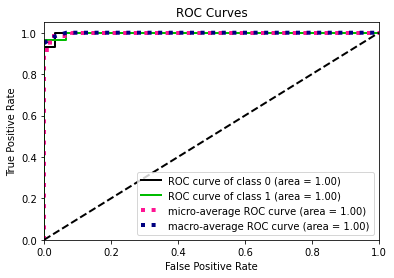

In [33]:
# epochs = 100
Labels = np.array([0, 1])
y_true = np.repeat(Labels, [30, 30], axis=0)
pred = test_pred[:,0]

skplt.metrics.plot_roc_curve(y_true, test_pred)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


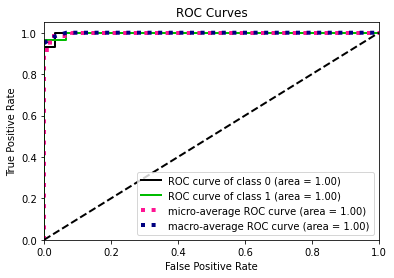

In [34]:
# epochs = 500
Labels = np.array([0, 1])
y_true = np.repeat(Labels, [30, 30], axis=0)
pred = test_pred[:,0]

skplt.metrics.plot_roc_curve(y_true, test_pred)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


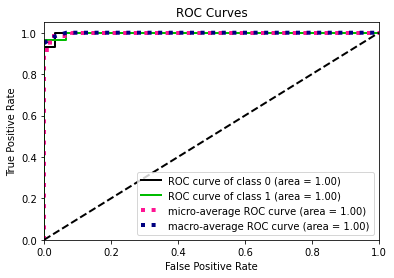

In [35]:
# PretrainedVGG.hdf5 모델 적용 결과
Labels = np.array([0, 1])
y_true = np.repeat(Labels, [30, 30], axis=0)
pred = test_pred[:,0]

skplt.metrics.plot_roc_curve(y_true, test_pred)
plt.show()

그려진 ROC Curve.

0은 Akiec, 1은 Melanoma를 의미.

Skin classification은 딥러닝이 해결할 수 있는 매우 좋은 예제로,

성능이 아주 좋은것을 확인할 수 있다.

In [37]:
#Feature 확인 

Files = os.listdir(test_directory+'melanoma')
for i in range(len(Files)):
	img_path = CurrentDirectory+"/TEST/melanoma/"+Files[i]
	output_path = CurrentDirectory + 'Heatmap_' + Files[i]

	img = image.load_img(img_path, target_size=(224, 224))
	x = image.img_to_array(img)
	x = np.expand_dims(x, axis=0)

	x = preprocess_input(x)
	preds = DeepLearning.predict(x)

	argmax = np.argmax(preds[0])
	output = DeepLearning.output[:, argmax]
	last_conv_layer = DeepLearning.get_layer('conv2d_12')

	grads = K.gradients(output, last_conv_layer.output)[0]
	pooled_grads = K.mean(grads, axis=(0, 1, 2))
	iterate = K.function([DeepLearning.input], [pooled_grads, last_conv_layer.output[0]])
	pooled_grads_value, conv_layer_output_value = iterate([x])

	for i in range(512):
		conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
	heatmap = np.mean(conv_layer_output_value, axis=-1)
	heatmap = np.maximum(heatmap, 0)
	heatmap /= np.max(heatmap)

	img = cv2.imread(img_path)
	heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
	heatmap = np.uint8(255 * heatmap)
	heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
	hif = .8
	superimposed_img = heatmap * hif+ img

	ax = plt.subplot(1,2,1)
	ax.imshow(img)
	ax = plt.subplot(1,2,2)
	ax.imshow(img)
	ax.imshow(255-heatmap, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
	plt.savefig(output_path, bbox_inches = 'tight')


ValueError: ignored

그려진 Heatmap은 빨갛게 그려진 부분이 예측할때 주요하게 사용된 Feature map의 GAP 결과라고 해석할 수 있다.

** 텐서보드 사용법

1. 텐서보드 설치하기

2. cmd 열어 command 입력 

예시): 

 1) cd 'runs' 폴더가 저장된 디렉토리 (runs 폴더를 다운로드 받은 위치)

 2) tensorboard --logdir=runs --samples_per_plugin=images=50

다음과 같은 창이 뜨면 성공임. 표시된 주소인 http://localhost:6006/ 으로 접속하여 결과를 확인하자. (주소는 바꿀 수 있음)

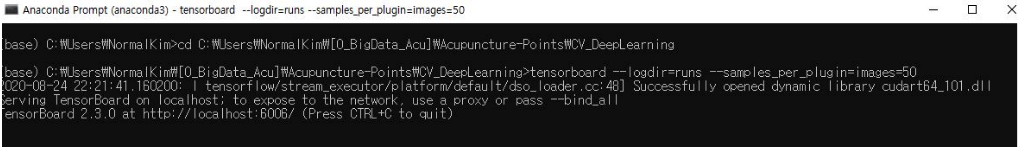

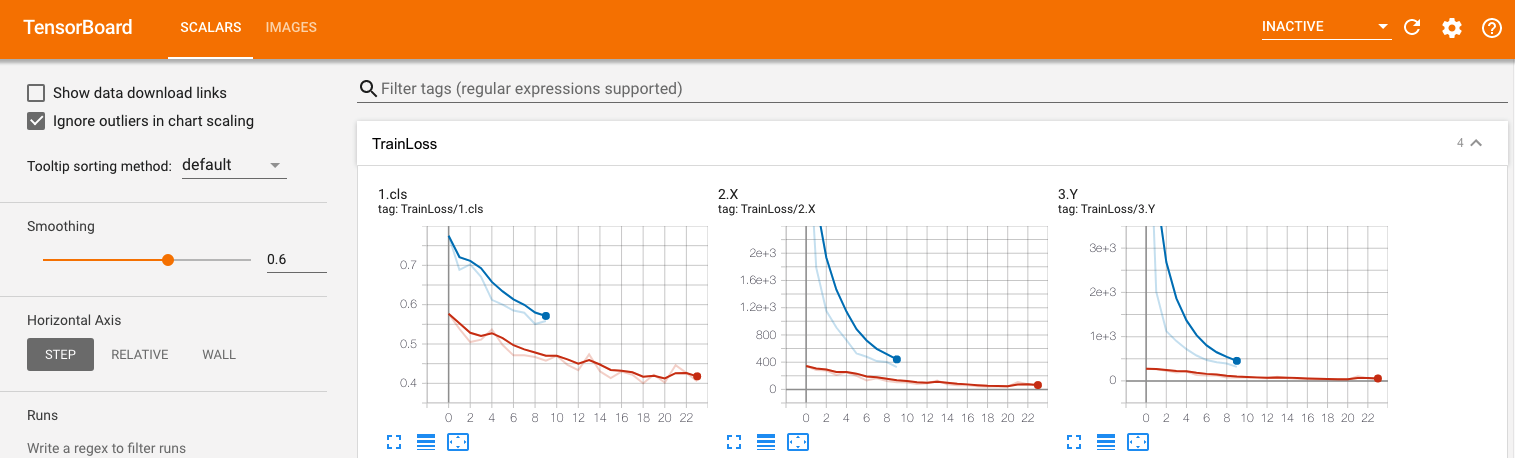

Tensorboard로 Accuracy가 어떻게 변하는지 그래프를 볼 수 있음 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tensorboard_directory --samples_per_plugin=images=50

In [ ]:
%reload_ext tensorboard